# Model evaluation notebook

in this notebook we will evaluate % availability. definitions are:

X = hour, dow, weekend, holiday, is_sunny, caiso, site_id
y = % available (for site)

this will work for all sites.

How will we do train test split?
random 80-20 for now 


In [2]:
import time
import os
if 'model_notebooks' == os.getcwd().split('/')[-1]: os.chdir('..')
if 'ev_charging' == os.getcwd().split('/')[-1]: print('in the right place!')
else: os.chdir('/Users/varunvenkatesh/Documents/Github/ev_charging')
os.getcwd()

in the right place!


'/home/denny/Documents/mids/ev_charging'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

from src.data_preprocessing import  datetime_processing, userinput_processing, holiday_processing, create_all_site_x, create_all_site_y, create_x, update_varuns_x, get_start_end_times

In [4]:
df_c = pd.read_parquet('data/sessions/caltech/').reset_index(drop=True)
df_c = datetime_processing(df_c)
df_c = userinput_processing(df_c)

df_j = pd.read_parquet('data/sessions/jpl/').reset_index(drop=True)
df_j = datetime_processing(df_j)
df_j = userinput_processing(df_j)

df_o = pd.read_parquet('data/sessions/office001/').reset_index(drop=True)
df_o = datetime_processing(df_o)
df_o = userinput_processing(df_o)

cols = list(df_c.columns)
df = pd.concat([df_c[cols], df_j[cols], df_o[cols]], axis=0)

In [5]:
print(f'df is a dataframe comprised of these site ids: {list(df.siteID.unique())}')

df is a dataframe comprised of these site ids: [2, 1, 19]


# Make X and y

In [6]:
start = '2018-05-01'
end = '2021-09-13'
spaceID = 'CA-303'
caiso_fp = 'data/caiso_dataset_5min.csv'
sun_fp = 'data/ct_sr_ss.csv'

In [7]:
X = pd.DataFrame()
sites_df = [df_o,df_c,df_j]
site_ids = [2,1,19]
caiso_fp = 'data/caiso_dataset_5min.csv'


for sdf, id, sun_fp in zip(sites_df, site_ids, ['data/of_sr_ss.csv','data/ct_sr_ss.csv', 'data/jpl_sr_ss.csv'] ):
    start, end = get_start_end_times(sdf)
    tmpx = create_x(start, end, caiso_fp, sun_fp)
    tmpx = update_varuns_x(tmpx, id)
    
    if X.empty:
        X = tmpx
    else:
        X = pd.concat([X, tmpx], axis=0)
    

/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:199: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:199: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['date'] + ' ' + sun['sunset'], errors='coerce', utc=True)
/home/denny/Documents/mids/ev_charging/src/data_preprocessing.py:199: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sun['sunset_ts'] = pd.to_datetime(sun['d

In [8]:
X['siteID'].value_counts().sum() == X.shape[0]
print(f'there are {X.shape[0]} records')

there are 77715 records


# Deal with covid
we found (graphically) that covid effects start around march 3rd 2020, so we truncated our data to march 1st. Since we did not have dates that contained post covid data, we did not include any charges after 2020-03-01 

In [9]:
x = X[X.index < '2020-03-01']
x.index.max()


Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [10]:
cols = list(df_c.columns)
df = pd.concat([df[cols] for df in sites_df], axis=0)
y = create_all_site_y(df, regression=True)

In [11]:
assert X.shape[0] == y.shape[0], 'X and y rows are not equal!'

In [12]:
y = y[y.index < '2020-03-01']
y.index.max()

Timestamp('2020-02-29 23:00:00+0000', tz='UTC')

In [13]:
assert x.shape[0] == y.shape[0], 'forgot to trim y\'s covid!'

In [14]:
y.shape

(37320,)

In [15]:
x.shape

(37320, 29)

# Modeling
In this section we will compare 

- linear regression models
- XGBoost regression, and 
- LSTM

models using the evaluation metric of RMSE

## LR

In [16]:
x.columns
cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]
x[cat_cols]
x[num_cols].columns

Index(['Day ahead forecast', 'Hour ahead forecast', 'Current demand',
       'Net demand', 'Solar', 'Wind', 'Geothermal', 'Biomass', 'Biogas',
       'Small hydro', 'Coal', 'Nuclear', 'Natural gas', 'Large hydro',
       'Batteries', 'Imports', 'Other', 'Biogas CO2', 'Biomass CO2',
       'Natural Gas CO2', 'Coal CO2', 'Imports CO2', 'Geothermal CO2'],
      dtype='object')

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


linear_regression_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('lr', LinearRegression()),
        ]
)

linear_regression_model.fit(X_train, y_train)

print(f'training RMSE: {np.sqrt(mean_squared_error(linear_regression_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(linear_regression_model.predict(X_test), y_test))}')
print(f'training R2: {linear_regression_model.score(X_train, y_train)}\ntest R2    : {linear_regression_model.score(X_test, y_test)}')
r2_score(linear_regression_model.predict(X_train), y_train)

training RMSE: 0.1921984867906563
test RMSE    : 0.19417795252788447
training R2: 0.5373015456486764
test R2    : 0.5341854474033855


0.1388477139169333

In [21]:
start = time.time()
pred = linear_regression_model.predict(X_test)
print('inference time: ', time.time()- start)

inference time:  0.022181272506713867


Text(0, 0.5, '% available')

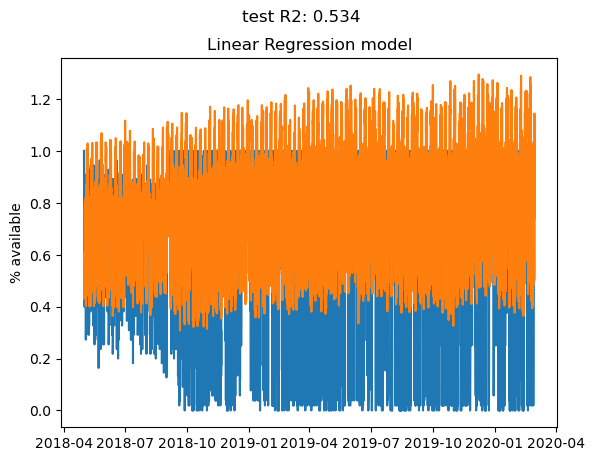

In [22]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(linear_regression_model.predict(X_test), index=X_test.index)
plt.title('Linear Regression model')
plt.suptitle(f'test R2: {np.round(linear_regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

## Check LR model coefficients

In [23]:
import statsmodels.api as sm

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

x_train_num = numeric_transformer.fit_transform(x[num_cols])
x_train_cat = categorical_transformer.fit_transform(x[cat_cols])
x_train = np.concatenate([x_train_num, x_train_cat], axis=1)
cols = np.concatenate([numeric_transformer.get_feature_names_out(),categorical_transformer.get_feature_names_out()])
X2 = sm.add_constant(x_train)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.537
Model:                            OLS   Adj. R-squared:                  0.536
Method:                 Least Squares   F-statistic:                     644.7
Date:                Sun, 14 Apr 2024   Prob (F-statistic):               0.00
Time:                        18:37:05   Log-Likelihood:                 8527.1
No. Observations:               37320   AIC:                        -1.692e+04
Df Residuals:                   37252   BIC:                        -1.634e+04
Df Model:                          67                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6805      0.008     85.933      0.0

In [24]:
const_cols = np.append(['const'], cols)
df = pd.DataFrame(est2.params, columns=['coef_value'])
df['feature_names'] = const_cols
df['p-values'] = est2.pvalues
df['important'] = df['p-values'] < 0.05
df['xgb_feat_name'] = df.index
df

,coef_value,feature_names,p-values,important,xgb_feat_name
const,0.680474,const,0.000000e+00,True,const
x1,-0.004081,Day ahead forecast,6.244983e-01,False,x1
x2,-0.002084,Hour ahead forecast,9.480306e-01,False,x2
x3,-0.035806,Current demand,3.123746e-01,False,x3
x4,0.044660,Net demand,3.402829e-03,True,x4
...,...,...,...,...,...
x63,0.040888,month_12,1.390495e-16,True,x63
x64,0.007269,is_sunny_1,1.519147e-01,False,x64
x65,0.159323,is_holiday_True,2.112457e-145,True,x65
x66,0.056377,siteID_2,4.437278e-91,True,x66


# XGBoost

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')


xgb_model = Pipeline(
    steps=[
        ('preprocessing', ColumnTransformer(
            transformers=[
                ("num", numeric_transformer, num_cols),
                ("cat", categorical_transformer, cat_cols),
            ])),
        ('xgb', XGBRegressor()),
        ]
)

xgb_model.fit(X_train, y_train)
print(f'training RMSE: {np.sqrt(mean_squared_error(xgb_model.predict(X_train), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(xgb_model.predict(X_test), y_test))}')
print(f'training r2: {xgb_model.score(X_train, y_train)}\ntest r2    : {xgb_model.score(X_test, y_test)}')

training RMSE: 0.07782280263818667
test RMSE    : 0.09978191665024623
training r2: 0.9243469566968695
test r2    : 0.8756472064789446


In [26]:
start = time.time()
pred = xgb_model.predict(X_test)
print('inference time: ', time.time()- start)

0.01830577850341797


Text(0, 0.5, '% available')

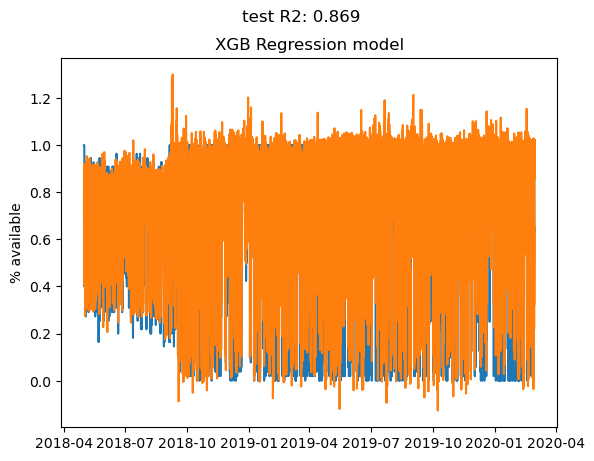

In [51]:
X_test = X_test.sort_index()
y_test = y_test.sort_index()
pred = pd.Series(xgb_model.predict(X_test), index=X_test.index)
plt.title('XGB Regression model')
plt.suptitle(f'test R2: {np.round(xgb_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')

## Show feature importance

In [27]:
col_names = xgb_model.named_steps['preprocessing'].get_feature_names_out()
model = xgb_model.named_steps['xgb']
# https://stackoverflow.com/a/74967040/6432367
model.get_booster().feature_names = list(col_names)
feature_importance = model.get_booster().get_score()


Text(0.5, 1.0, 'Feature importance by weight: ‘weight’ - the number of times a feature is used to split the data across all trees.')

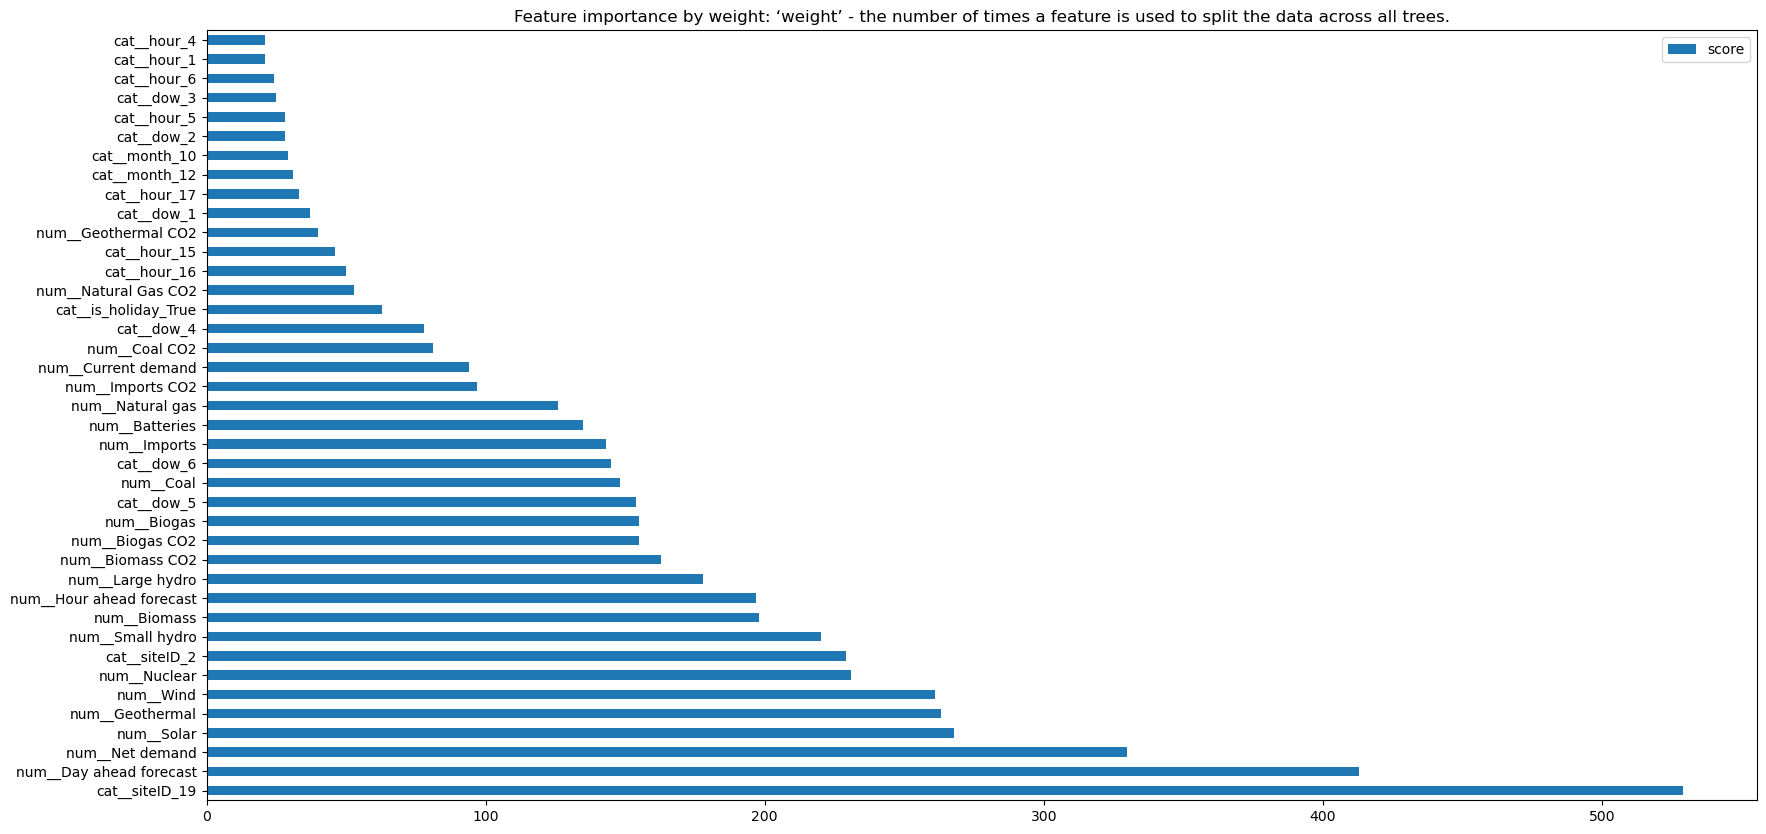

In [28]:
feature_important = model.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
# plt.title('Feature importance by gain: ‘gain’ - the average gain across all splits the feature is used in.')
plt.title('Feature importance by weight: ‘weight’ - the number of times a feature is used to split the data across all trees.')

## Plot XGB Tree for visualization

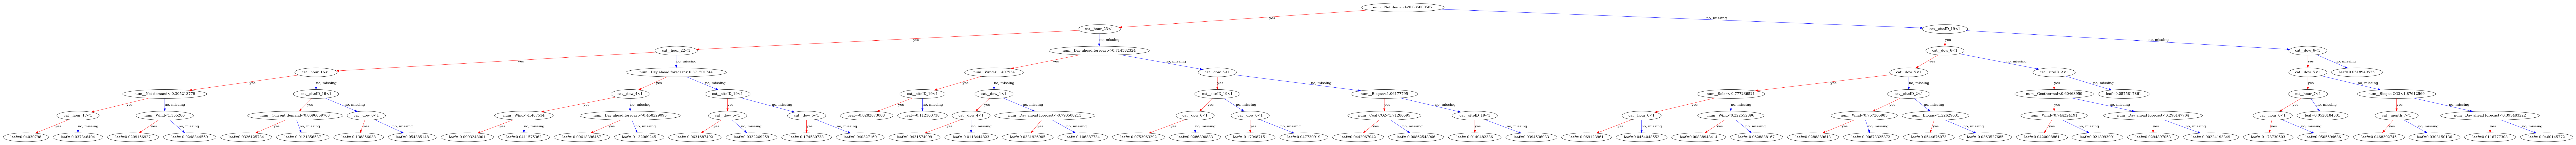

In [29]:
from xgboost import plot_tree

# plot single tree
plot_tree(model, num_trees=0)
fig = plt.gcf()
fig.set_size_inches(150, 100)
fig.savefig('tree.png')
fig.savefig('tree_high_dpi', dpi=100)
plt.show()

In [30]:
feature_important = model.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.sort_values('score', ascending=False)

,score
cat__hour_23,6.402952
cat__hour_7,5.807570
cat__hour_22,5.690031
cat__hour_6,4.891594
cat__hour_21,2.692583
...,...
cat__hour_20,0.104506
num__Imports,0.083481
num__Imports CO2,0.065623
num__Batteries,0.056515


# LSTM

In [31]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
tf.random.set_seed(42)
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = .2)

cat_cols = ['dow', 'hour', 'month', 'is_sunny', 'is_holiday','siteID']
num_cols = [col for col in x.columns if col not in cat_cols]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first')

X_train_1 = pd.DataFrame(numeric_transformer.fit_transform(X_train[num_cols]))
X_train_2 = pd.DataFrame(categorical_transformer.fit_transform(X_train[cat_cols]))
X_train_enc = pd.concat([X_train_1, X_train_2], axis=1)
X_train_enc = np.reshape(X_train_enc.values.astype(float), (X_train_enc.shape[0], 1, X_train_enc.shape[1]))

def create_lstm():
    model = Sequential()
    model.add(LSTM(7, input_shape=(1, X_train_enc.shape[2])))
    model.add(Dropout(0.2))
    model.add(Dense(7, activation='selu'))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

lstm_regression_model = create_lstm()
lstm_regression_model.fit(X_train_enc, y_train, epochs=10, batch_size=8, verbose=2)

# print(f'training RMSE: {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_train_enc), y_train))}\ntest RMSE    : {np.sqrt(mean_squared_error(lstm_regression_model.predict(X_test_enc), y_test))}')
#print(f'training loss: {regression_model.score(X_train, y_train)}\ntest loss    : {regression_model.score(X_test, y_test)}')

2024-04-14 18:37:43.333680: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-14 18:37:43.335675: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 18:37:43.428720: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-04-14 18:37:43.800860: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-14 18:37:45.613319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warnin

Epoch 1/10
3732/3732 - 8s - 2ms/step - loss: 0.0485
Epoch 2/10
3732/3732 - 5s - 1ms/step - loss: 0.0183
Epoch 3/10
3732/3732 - 5s - 1ms/step - loss: 0.0152
Epoch 4/10
3732/3732 - 4s - 1ms/step - loss: 0.0142
Epoch 5/10
3732/3732 - 5s - 1ms/step - loss: 0.0135
Epoch 6/10
3732/3732 - 4s - 1ms/step - loss: 0.0130
Epoch 7/10
3732/3732 - 4s - 1ms/step - loss: 0.0127
Epoch 8/10
3732/3732 - 5s - 1ms/step - loss: 0.0123
Epoch 9/10
3732/3732 - 4s - 1ms/step - loss: 0.0120
Epoch 10/10
3732/3732 - 4s - 1ms/step - loss: 0.0117


In [33]:
X_test = X_test.sort_index()
X_test_1 = pd.DataFrame(numeric_transformer.transform(X_test[num_cols]))
X_test_2 = pd.DataFrame(categorical_transformer.transform(X_test[cat_cols]))
X_test_enc = pd.concat([X_test_1, X_test_2], axis=1)
X_test_enc = np.reshape(X_test_enc.values.astype(float), (X_test_enc.shape[0], 1, X_test_enc.shape[1]))

In [34]:
start = time.time()
pred = lstm_regression_model.predict(X_test_enc)
print('inference time: ', time.time()- start)

234/234 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
inference time:  0.8850493431091309


234/234 ━━━━━━━━━━━━━━━━━━━━ 0s 692us/step


Text(0, 0.5, '% available')

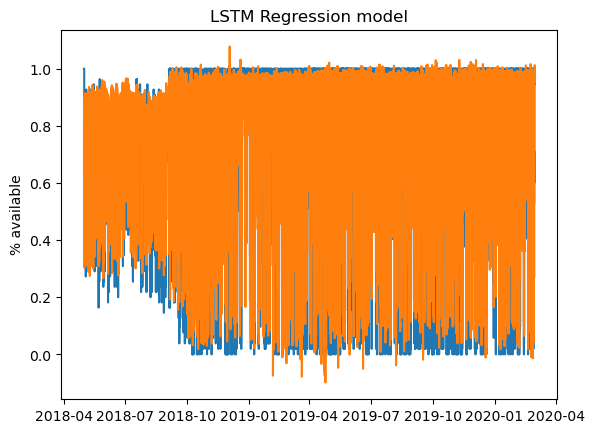

In [31]:
y_test = y_test.sort_index()
pred = lstm_regression_model.predict(X_test_enc)
plt.title('LSTM Regression model')
#plt.suptitle(f'test R2: {np.round(regression_model.score(X_test, y_test),3)}')
plt.plot(y_test.index, y_test)
plt.plot(y_test.index, pred)
plt.ylabel('% available')